# Clasifición de recuperados y no recuperados utilizando SMOTE

A continuación vamos a balancear nuestro dataset (cantidad de autos recuperados vs. no recuperados) subsampleando la clase mayoritaria (autos no recuperados ~95%) y sobresampleando la clase minoritaria (autos recuperados ~5%).

## Preparación y caracterización del dataset

In [24]:
# Cargamos las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [25]:
# Cargamos los datos y dropeamos NaNs y una columna que quedó de más
data_total = pd.read_csv('./curados/ULTIMATE_DATASET.csv')
data_total.dropna(inplace=True) # Dropeamos NaNs
data_total.drop(['Unnamed: 0'], axis=1, inplace=True) # Dropeamos una columna extra

In [26]:
# Vemos cuántas denuncias de robo hay (es decir, cuántos no recuperados) y cuántas notificaciones
# de recupero hay (es decir, recuperados)
print("Hay "+ str(data_total['tramite_tipo'].value_counts()[0])+ ' no recuperados y '+
              str(data_total['tramite_tipo'].value_counts()[1])+ ' recuperados')
print("El porcentaje de recuperados en el dataset es "+ 
      str(round(data_total['tramite_tipo'].value_counts()[1]/data_total['tramite_tipo'].value_counts()[0],3)*100)+ ' %')

Hay 59986 no recuperados y 2925 recuperados
El porcentaje de recuperados en el dataset es 4.9 %


In [27]:
#cambio los valores de la columna tramite_tipo apra que robado sea 0 y recuperado 1
data_total['tramite_tipo'] = data_total['tramite_tipo'].map({'DENUNCIA DE ROBO O HURTO': 0, 
                                                             'COMUNICACIÓN DE RECUPERO': 1})

# Y cambiamos el nombre de la columna a "recuperados" con 0 cuando no están recuperados y 1 cuando
# si fueron recuperados
data_total = data_total.rename(columns={'tramite_tipo':'recuperados'})

In [28]:
# List de las columnas
data_total.columns

Index(['recuperados', 'tramite_fecha', 'fecha_inscripcion_inicial',
       'registro_seccional_descripcion', 'registro_seccional_provincia',
       'automotor_origen', 'automotor_anio_modelo',
       'automotor_tipo_descripcion', 'automotor_marca_descripcion',
       'automotor_modelo_descripcion', 'automotor_uso_descripcion',
       'titular_tipo_persona', 'titular_domicilio_localidad',
       'titular_domicilio_provincia', 'titular_genero',
       'titular_anio_nacimiento', 'titular_pais_nacimiento', 'unico_duenio',
       'dia_anio'],
      dtype='object')

In [29]:
# Dropeamos las columnas 'registro_seccional_descripcion' y 'titular_domicilio_localidad' porque
# no las consideramos relevantes para la prediccioón
data_total.drop(['registro_seccional_descripcion', 'titular_domicilio_localidad',], 
                axis= 1, inplace = True)

In [30]:
# Convertimos las fechas a datetime64
data_total['tramite_fecha']             = pd.to_datetime(data_total['tramite_fecha'])
data_total['fecha_inscripcion_inicial'] = pd.to_datetime(data_total['fecha_inscripcion_inicial'])

In [32]:
# Creamos columnas con el día, mes y año de robo más una columna con el año de patentamiento
data_total['dia_robo'] = data_total['tramite_fecha'].apply(lambda x: int(x.isoweekday())) #lunes es 1, domingo 7
data_total['mes_robo'] = data_total['tramite_fecha'].apply(lambda x: int(x.month))
data_total['dia_del_anio'] = data_total['tramite_fecha'].apply(lambda x: int(x.timetuple().tm_yday))
data_total['anio_pat'] = data_total['fecha_inscripcion_inicial'].apply(lambda x: int(x.year))

In [33]:
# Una nueva columna que dice si el titular está radicado en la misma provincia que el auto
data_total['tit_radicado'] = ((data_total['registro_seccional_provincia']).apply(lambda x: x.upper()) == data_total['titular_domicilio_provincia']).astype(int)

In [34]:
# Finalmente dropeamos las columnas que utilizamos para crear estas columnas aucxiliares
data_total.drop(['tramite_fecha', 'fecha_inscripcion_inicial', 'titular_domicilio_provincia'], axis = 1, inplace= True)
data_total.head(3)

,recuperados,registro_seccional_provincia,automotor_origen,automotor_anio_modelo,automotor_tipo_descripcion,automotor_marca_descripcion,automotor_modelo_descripcion,automotor_uso_descripcion,titular_tipo_persona,titular_genero,titular_anio_nacimiento,titular_pais_nacimiento,unico_duenio,dia_anio,dia_robo,mes_robo,dia_del_anio,anio_pat,tit_radicado
0,0,Buenos Aires,Nacional,2000.0,SEDAN 4 P,CHEVROLET,CORSA,Privado,Física,Masculino,1981.0,ARGENTINA,1,17,3,1,17,2000,1
1,0,Buenos Aires,Nacional,2007.0,FURGON,PEUGEOT,PARTNER,Privado,Física,Femenino,1990.0,ARGENTINA,1,3,3,1,3,2007,1
2,0,Buenos Aires,Nacional,1995.0,SEDAN 4 P,RENAULT,RENAULT 19,Privado,Física,Masculino,1986.0,ARGENTINA,1,12,5,1,12,1995,1


A continuación vamos a generar los dummies correspondientes a las columnas que utilizaremos en los modelos de predicción.

In [35]:
prov_dummie     = pd.get_dummies(data_total.registro_seccional_provincia)
origen_dummie   = pd.get_dummies(data_total.automotor_origen)
tipo_dummie     =  pd.get_dummies(data_total.automotor_tipo_descripcion)
marca_dummie    = pd.get_dummies(data_total.automotor_marca_descripcion)
modelo_dummie   = pd.get_dummies(data_total.automotor_modelo_descripcion)
uso_dummie      = pd.get_dummies(data_total.automotor_uso_descripcion)
pais_tit_dummie = pd.get_dummies(data_total.titular_pais_nacimiento)
# MARCA NO LA NECESITAMOS, CON MODELO YA TENÉS MARCA

In [36]:
# Correción de algunos dummies
tipo_dummie = tipo_dummie.rename(columns={'PICK UP':'PICK UP tipo'})
data_total  = data_total.join([prov_dummie, origen_dummie, tipo_dummie,  modelo_dummie, uso_dummie, pais_tit_dummie, marca_dummie]) #marca_dummie,

In [38]:
# Creamos dummies para las variables con dos niveles
data_total['titular_pers_fisica'] = np.where(data_total['titular_tipo_persona'] == 'Física', 1, 0)
data_total['titular_masculino']   = np.where(data_total['titular_genero'] == 'Masculino', 1, 0)

In [41]:
tipo_dummie.iloc[:,:-1].head()

,ACOPLADO,AMBULANCIA,ARENERO,CAMION,CASA RODANTE,CHASIS CON CABINA,COMBI,COMERCIAL LIVIANO,COUPE,DESCAPOTABLE,...,OTROS,PICK UP tipo,SEDAN,SEDAN 3 P,SEDAN 4 P,SEMIRREMOLQUE,TODO TERRENO,TRACTOR,TRANSP. PASAJEROS,UTILITARIO
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Join con las dummies descartando la ultima columna
data_total = data_total.join([prov_dummie.iloc[:,:-1], origen_dummie.iloc[:,:-1], 
                              tipo_dummie.iloc[:,:-1], modelo_dummie.iloc[:,:-1], 
                              uso_dummie.iloc[:,:-1], pais_tit_dummie.iloc[:,:-1], 
                              marca_dummie.iloc[:,:-1]]) #marca_dummie,

In [45]:
# Dropeamos las columnas a partir de las cuales generamos los dummies
data_total.drop(['registro_seccional_provincia', 'automotor_origen', 'automotor_uso_descripcion','automotor_tipo_descripcion',
        'automotor_marca_descripcion', 'automotor_modelo_descripcion','titular_pais_nacimiento', 
       'titular_tipo_persona', 'titular_genero'], axis= 1, inplace = True)

KeyError: "['registro_seccional_provincia' 'automotor_origen'\n 'automotor_uso_descripcion' 'automotor_tipo_descripcion'\n 'automotor_marca_descripcion' 'automotor_modelo_descripcion'\n 'titular_pais_nacimiento' 'titular_tipo_persona' 'titular_genero'] not found in axis"

In [46]:
np.shape(data_total)

(62911, 1996)

## Preparación de los datos para el ajuste del modelo

In [47]:
# Separación entre x e y
x = data_total.drop('recuperados', axis = 1)
y = data_total.recuperados

In [48]:
# Verifico que no haya NANs en x
np.where(np.isnan(x))

(array([], dtype=int64), array([], dtype=int64))

In [55]:
round(ytest.sum()/np.shape(ytest)[0],2)

0.05

In [61]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
print("La proporción de recuperados en el test es "+ str(round(ytest.sum()/np.shape(ytest)[0],2)))
print("La proporción de recuperados en el train es "+ str(round(ytrain.sum()/np.shape(ytrain)[0],2)))

La proporción de recuperados en el test es 0.05
La proporción de recuperados en el test es 0.05


Vemos que la proporción de recuperados es, aproximadamente, .05 en el train y el test set. Es decir, la estratificación funcionó bien.

## Undersampling con random

Lo primero que voy a hacer es probar randowm undersampling, es deir, borrar muestras de la majority al azar. Me quedo con N muestras, que en este caso lo puse como un tercio de los autos no recuperados.

In [62]:
# Mezclamos el dataset
shuffled_df = xtrain.sample(frac=1,random_state=4)

# Todos los recuperados por un lado
recup_df = xtrain.loc[ytrain == 1]
recup_df["recup"] = ytrain.loc[ytrain == 1]

# Los no recuperados por otro lado
no_recup_df = xtrain.loc[ytrain == 0]
no_recup_df["recup"] = ytrain.loc[ytrain == 0]

# Me quedo con N samples de los no recuperados
N = round(no_recup_df.shape[0]/3) # Me quedo con un tercio
no_recup_df = no_recup_df.sample(n=N,random_state=42)

In [63]:
undersampled_xtrain = pd.concat([recup_df, no_recup_df], ignore_index=True)
undersampled_ytrain = undersampled_xtrain["recup"]
undersampled_xtrain.drop('recup', axis=1, inplace=True)

## Oversampling con SMOTE

SMOTE me permite aumentar el número de muestras de la minoría hasta una cierta proporción de la mayoría (dada en el código por *prop*).

In [64]:
from imblearn.over_sampling import SMOTE

prop = .5 # Es decir, la minería va a ser prop veces la mayoría

# Resampleo la minoría
sm = SMOTE(sampling_strategy=prop, random_state=7)

# Fiteo el modelo para generar la nueva data sintética
oversampled_xtrain, oversampled_ytrain = sm.fit_sample(undersampled_xtrain, undersampled_ytrain)

In [65]:
print("La cantidad de muestras originales es " + str(undersampled_xtrain.shape[0]))
print("La cantidad de muestras aumentadas es " + str(oversampled_xtrain.shape[0]))

La cantidad de muestras originales es 16044
La cantidad de muestras aumentadas es 20995


In [66]:
print("La cantidad de recuperados originales es " + str(undersampled_ytrain.sum()))
print("La cantidad de recuperados aumentados es " + str(oversampled_ytrain.sum()))

La cantidad de recuperados originales es 2047
La cantidad de recuperados aumentados es 6998


In [67]:
print("La proporción de recuperados en la muestra aumentada es " + str(oversampled_ytrain.sum()/oversampled_xtrain.shape[0]))

La proporción de recuperados en la muestra aumentada es 0.3333174565372708


Vamos a hacer un random forest con el smote

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [34]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [20,50],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [40],
    'criterion' :['gini']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(oversampled_xtrain, oversampled_ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [35]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'sqrt',
 'n_estimators': 50}

In [36]:
rfc1=RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 30, max_depth=40, criterion='gini')
rfc1.fit(oversampled_xtrain, oversampled_ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [37]:
ypred = CV_rfc.predict(xtest)

In [38]:
cm_rf = confusion_matrix(ytest, ypred)
print(cm_rf)

[[17759   237]
 [  437   441]]


PCA con el oversampled

In [60]:
from sklearn.decomposition import PCA
# cantidad de componentes a extraer
n_comps = 5
# definimos PCA
pca = PCA(n_components= n_comps)
# fit_transform del PCA a nuestros datos
xpca = pd.DataFrame(pca.fit_transform(oversampled_xtrain))
# obtenemos los auto-valores
eigenvalues = pca.explained_variance_ratio_

In [61]:
xpca.shape

(20995, 5)

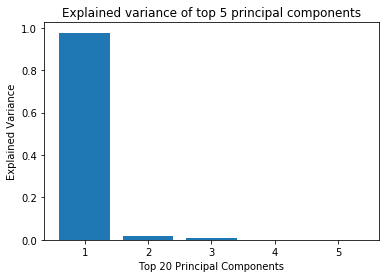

In [62]:
components = range(1,n_comps + 1)
plt.bar(components,eigenvalues)
plt.xticks(components)
plt.title('Explained variance of top 5 principal components')
plt.xlabel('Top 20 Principal Components')
plt.ylabel('Explained Variance')
plt.show()

Random Forest con PCA

In [63]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [20,50],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [40],
    'criterion' :['gini']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(xpca, oversampled_ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [64]:
xpca_test = pd.DataFrame(pca.fit_transform(xtest))

In [65]:
ypred = CV_rfc.predict(xpca_test)

In [66]:
cm_rf = confusion_matrix(ytest, ypred)
print(cm_rf)

[[14949  3047]
 [  424   454]]
